In [4]:
import opendatasets as od
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
from torchvision.utils import save_image
from tqdm import tqdm
import torch.nn.functional as F
from IPython.display import Image

import cv2
import os

In [5]:
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())

0


In [6]:
class Discriminator():
    def __init__(self, g1):
        self.g1 = g1
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

            nn.Flatten(),
            nn.Sigmoid())

class Generator():
    def __init__(self, g1):
        self.g1 = g1
        self.network = nn.Sequential(
        nn.ConvTranspose2d(g1.latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),

        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),

        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),

        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),

        nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )

In [7]:
class DeviceDataLoader():
    def __init__(self, f1, dl, device):
        self.dl = dl
        self.device = device
        self.f1 = f1
        
    def __iter__(self):
        for b in self.dl: 
            yield self.f1.to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [18]:
class GAN():
    def __init__(self):
        print("constructor")
        
    def init_hyp(self):
        self.image_size = 64
        self.batch_size = 256
        self.stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
        self.latent_size = 256
        self.lr = 0.002
        self.epoch = 500
        self.DATA_DIR = './data/naruto-cropped-all/'
        
    
    def init_obj(self):
        self.disc = Discriminator(self).network
        self.genr = Generator(self).network
        self.device = self.get_default_device()
        self.to_device(self.disc, self.device)
        self.to_device(self.genr, self.device)
        self.fixed_latent = torch.randn(64, self.latent_size, 1, 1, device=self.device)
        
    def get_data(self):
#         dataset_url = 'https://www.kaggle.com/kvpratama/pokemon-images-dataset'
        od.download(dataset_url)
        
    def show_data(self):
        print(os.listdir(self.DATA_DIR)[:10])
    
    def init_data(self):
        self.init_hyp()
        self.init_obj()
        
        self.train_ds = ImageFolder(self.DATA_DIR, transform=T.Compose([
        T.Resize(self.image_size),
        T.CenterCrop(self.image_size),
        T.ToTensor(),
        T.Normalize(*self.stats)]))
        
#         print("shape", self.train_ds.size)
        self.train_dl = DataLoader(self.train_ds, self.batch_size, shuffle=True, num_workers=4, pin_memory=True)
        self.train_dl = DeviceDataLoader(self, self.train_dl, self.device)
        
    
    def denorm(self, img_tensors):
        return img_tensors * self.stats[1][0] + self.stats[0][0]
    
    def show_image(self):
        for i, l in self.train_dl:
            plt.imshow(i[49].cpu().permute(1, 2, 0))
            break
    
    def show_images(self, images, nmax=64):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(self.denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

    def show_batch(self, nmax=64):
        for images, _ in self.train_dl:
            self.show_images(images.cpu(), nmax)
            break
    
    def get_default_device(self):
        if torch.cuda.is_available():
            return torch.device('cuda')
        else:
            return torch.device('cpu')
    
    def to_device(self, data, device):
        if isinstance(data, (list,tuple)):
            return [self.to_device(x, device) for x in data]
        return data.to(device, non_blocking=True)
    
    def train_discriminator(self, real_images, opt_d):
        opt_d.zero_grad()

        real_preds = self.disc(real_images)
#         print("real_preds", real_preds)
        
        real_targets = torch.ones(real_images.size(0), 1, device=self.device)
#         print("real_targets", real_targets)
        
        real_loss = F.binary_cross_entropy(real_preds, real_targets)
        real_score = torch.mean(real_preds).item()

        latent = torch.randn(self.batch_size, self.latent_size, 1, 1, device=self.device)
        fake_images = self.genr(latent)

        fake_targets = torch.zeros(fake_images.size(0), 1, device=self.device)
        fake_preds = self.disc(fake_images)
        fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
        fake_score = torch.mean(fake_preds).item()

        loss = real_loss + fake_loss
        loss.backward()
        opt_d.step()
        return loss.item(), real_score, fake_score
    
    def train_generator(self, opt_g):
        # Clear generator gradients
        opt_g.zero_grad()

        # Generate fake images
        latent = torch.randn(self.batch_size, self.latent_size, 1, 1, device=self.device)
        fake_images = self.genr(latent)

        # Try to fool the discriminator
        preds = self.disc(fake_images)
        targets = torch.ones(self.batch_size, 1, device=self.device)
        loss = F.binary_cross_entropy(preds, targets)

        # Update generator weights
        loss.backward()
        opt_g.step()

        return loss.item()
    
    def save_samples(self, index, latent_tensors, show=True):
        sample_dir = './data/generated/naruto'
        os.makedirs(sample_dir, exist_ok=True)
        
        fake_images = self.genr(latent_tensors)
        fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
        save_image(self.denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
        print('Saving', fake_fname)
        if show:
            fig, ax = plt.subplots(figsize=(8, 8))
            ax.set_xticks([]); ax.set_yticks([])
            ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
    
    def fit(self, start_idx=1):
        torch.cuda.empty_cache()

        # Losses & scores
        losses_g = []
        losses_d = []
        real_scores = []
        fake_scores = []

        # Create optimizers
        opt_d = torch.optim.Adam(self.disc.parameters(), lr=self.lr, betas=(0.5, 0.999))
        opt_g = torch.optim.Adam(self.c.parameters(), lr=self.lr, betas=(0.5, 0.999))

        for epoch in range(self.epoch):
            for real_images, _ in tqdm(self.train_dl, position=0, leave=True):
                # Train discriminator
                loss_d, real_score, fake_score = self.train_discriminator(real_images, opt_d)
                # Train generator
                loss_g = self.train_generator(opt_g)

            # Record losses & scores
            losses_g.append(loss_g)
            losses_d.append(loss_d)
            real_scores.append(real_score)
            fake_scores.append(fake_score)

            # Log losses & scores (last batch)
            print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
                epoch+1, self.epoch, loss_g, loss_d, real_score, fake_score))

            # Save generated images
            if epoch%200 == 0:
                self.save_samples(epoch+start_idx, self.fixed_latent, show=False)

        return losses_g, losses_d, real_scores, fake_scores

In [19]:
gan = GAN()

constructor


In [20]:
gan.init_data()

In [21]:
gan.show_data()

['1698.jpg', '913.jpg', '81.jpg', '1037.jpg', '1387.jpg', '30.jpg', '1202.jpg', '1903.jpg', '969.jpg', '2611.jpg']


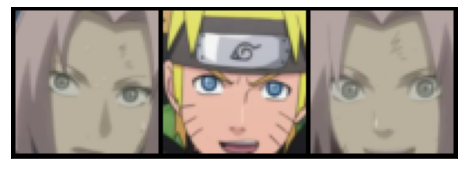

In [22]:
gan.show_batch()

In [17]:
# gan.show_image()

In [14]:
gan.train_dl

<!-- train the model -->
history = gan.fit()

In [ ]:
# save the model discriminator and generator paramters

torch.save(gan.disc, 'checkpoint/model-face-discriminator.pth')
torch.save(gan.genr, 'checkpoint/model-face-generator.pth')